# Logistic fits to rule-based condition

This script is used for model comparison for the rule-based logistic fits to the psychometric function in section:
"Rule- and stimulus-based biases had different effects on choices and RTs"

In [1]:
imatlab_export_fig('print-svg')

addpath('../logistic')

DATA_DIR = './data';

%eventually separate out this code and load model defs from a mat
fits(1).optionName = 'priorOnly';
fits(1).model_id = 1;
fits(1).fitmat = 'fits_lapse_priorOnly_full_01-Mar-2021.mat';
fits(2).optionName = 'priorOnly';
fits(2).model_id = 2;
fits(2).fitmat = 'fits_lapse_priorOnly_noint_01-Mar-2021.mat';
fits(3).model_id = 3;
fits(3).fitmat = 'fits_lapse_priorOnly_noprior_01-Mar-2021.mat';
fits(4).model_id = 6;
fits(4).fitmat = 'fits_lapse_priorOnly_adapt_27-Jul-2021.mat';

data = read_data_csv(...
    fullfile(DATA_DIR,'/priorOnly_pretoneOnly_pretone_pL_pretone_pH_pretone5_05-Feb-2021.csv'));
    

## load and plot data for shared slopes model

In [2]:
datapc = data(strcmp(data.optionName,fits(1).optionName),:);
%remove missing trials (should already be done)
datapc = datapc(~isnan(datapc.choice01),:);
datapc.zSNR = zscore(datapc.SNR);

In [3]:
%% plot shared slopes model

datapc_ave_subj = summary_stats(datapc,{'choice01'},...
    {'subject','prior','zSNR'});
datapc_ave_all = summary_stats(datapc_ave_subj,'mean_choice01',{'prior','zSNR'});
zsnrs = unique(datapc_ave_subj.zSNR);
priors = unique(datapc_ave_subj.prior);
fdat = cat(2, ones(100, 1), ...
    linspace(min(zsnrs), max(zsnrs), 100)');
co = {'b','k','r'};

In [4]:
%compute predictions for all Ss for shared slopes model

F = load(fullfile(DATA_DIR,fits(2).fitmat));

norms_shared = F.norms;
fits_lapse_shared = F.fits_lapse;clear F
fits_pred_shared = table();

for s=1:height(fits_lapse_shared)
    this_subj = fits_lapse_shared.subject(s);
    this_fits = fits_lapse_shared{s,1:5};
    for pp = 1:3
        %for each block, generate prediction
        this_fits_pred = array2table(logist_valLU1(this_fits([pp 4:5])', fdat),...
        'VariableNames',{'pred'});
        this_fits_pred.zSNR = fdat(:,2);
        this_fits_pred.subject = repmat(this_subj,height(this_fits_pred),1);
        this_fits_pred.prior = repmat(priors(pp),height(this_fits_pred),1);
        fits_pred_shared = [fits_pred_shared;this_fits_pred];
    end
end

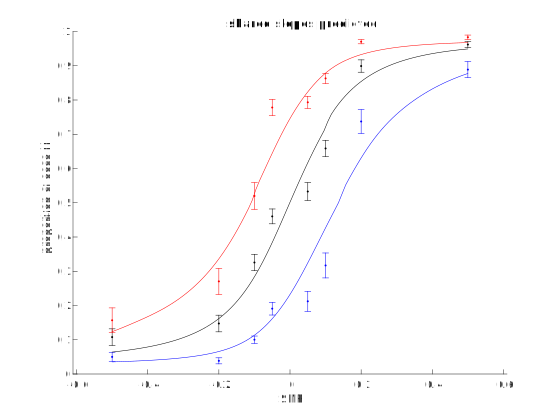

In [5]:
fits_pred_shared_ave = varfun(@mean,fits_pred_shared,'InputVariables','pred','GroupingVariables',...
    {'prior','zSNR'});
    
%convert zSNR to SNR
fits_pred_shared_ave.SNR = (fits_pred_shared_ave.zSNR.*norms_shared.SNR.sd) + norms_shared.SNR.mean;
datapc_ave_all.SNR = (datapc_ave_all.zSNR.*norms_shared.SNR.sd) + norms_shared.SNR.mean;

figure();hold on;
psycho_plot(datapc_ave_all,'prior',strcat('.',co),...
    'mean_mean_choice01','sem_mean_choice01',0,'SNR');
psycho_plot(fits_pred_shared_ave,'prior',strcat('-',co),...
    'mean_pred',[],0,'SNR');
    
xlabel('SNR')
ylabel('proportion choose H')
title('shared slopes predicted')

### Model comparison

In [6]:
%% load in fit data

lle = table();
for i=1:length(fits)-1
    F = load(fullfile(DATA_DIR,fits(i).fitmat));
    lle = [lle; F.fit_stats];
    clear F
end

lle.aic = 2.*lle.nparam - 2.*lle.LL;


lle_ave =

  3x8 table

    model_id    GroupCount    mean_LL    mean_aic    std_LL    std_aic    sem_LL    sem_aic
    ________    __________    _______    ________    ______    _______    ______    _______

       1            49        -195.93     405.86     52.781    105.56     7.5401     15.08 
       2            49        -198.08     406.16     53.065    106.13     7.5807    15.161 
       3            49        -227.38     460.76     60.181    120.36     8.5973    17.195 


delta_AIC =

    0.2947
   54.6040



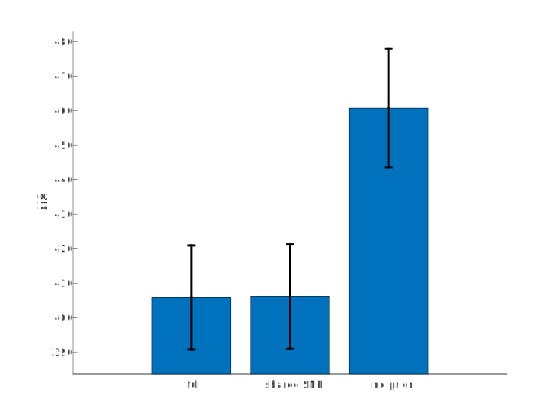

In [7]:
%FINAL

lle_ave = summary_stats(lle,{'LL','aic'},'model_id')

lle_sum = varfun(@sum,lle,'InputVariables',{'LL','aic'},...
    'GroupingVariables',{'model_id','mname','nparam'});

barplot(lle_ave.mean_aic,lle_ave.sem_aic,'xticklabel',{'full','shared SNR','no prior'},'ylabel','AIC');
ylim([min(lle_ave.mean_aic) - max(lle_ave.sem_aic)-5,...
    max(lle_ave.mean_aic) + max(lle_ave.sem_aic)+5])
delta_AIC = diff(lle_ave.mean_aic)

---
Date: 10-Nov-2021 13:49:43
VB converged in 12 iterations (took ~7 sec).
Dimensions:
     - subjects: n=49
     - models: K=3
Posterior probabilities:
     - RFX: p(H1|y)= 1.000
     - null: p(H0|y)= 0.000


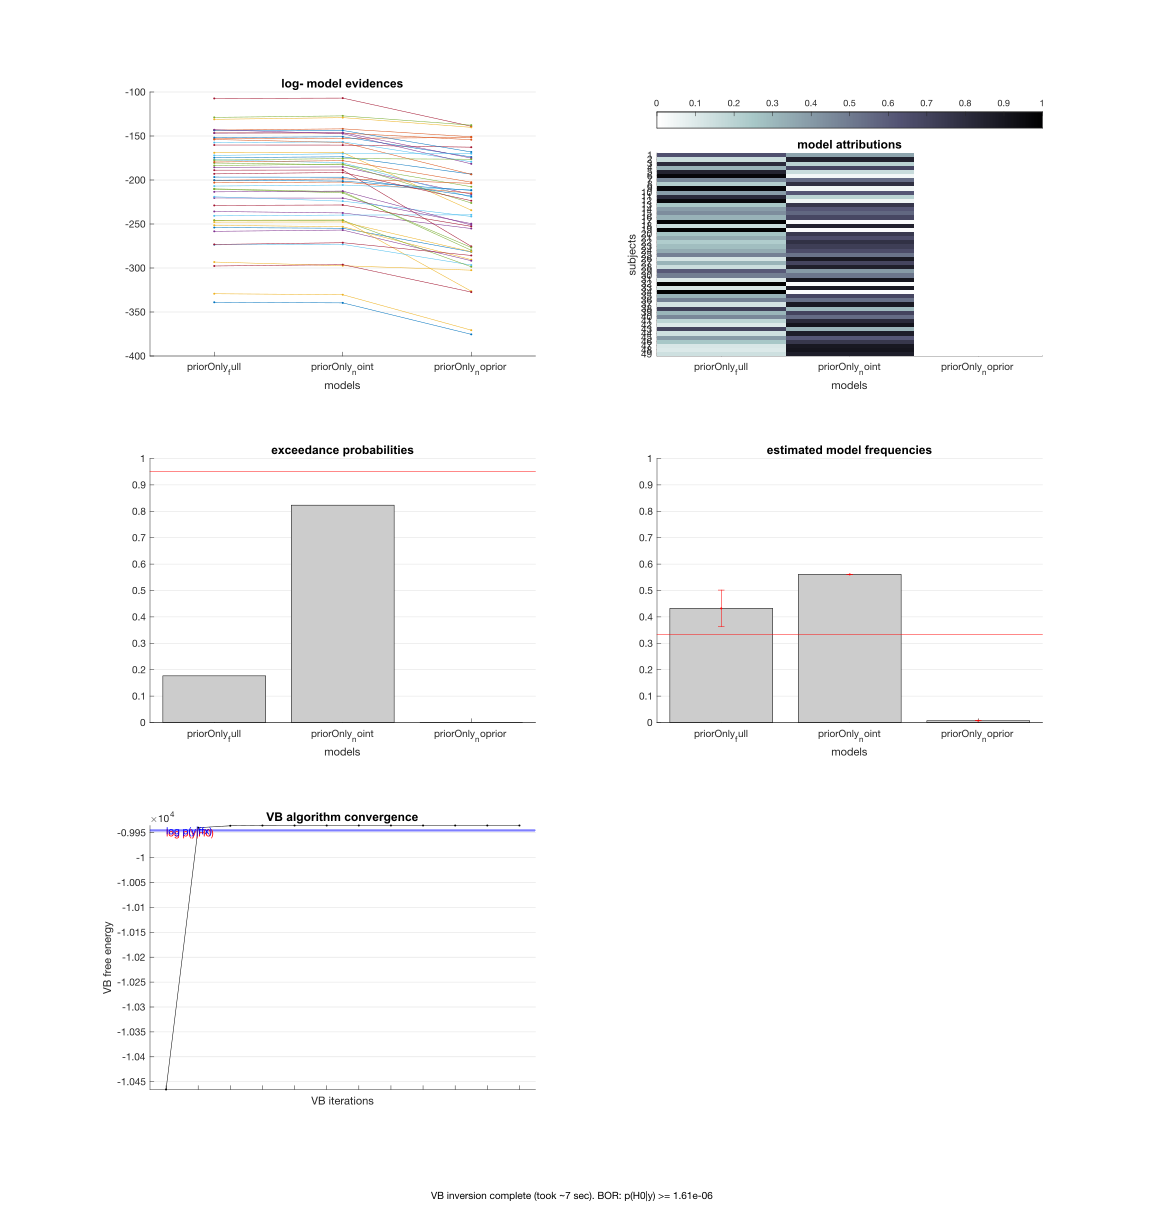

In [8]:
%FINAL

%% now let's look at exceedance probability
lle_VBA = lle(:,{'subject','mname','aic'});
%Stephan et al 2009 AIC is normal AIC/-2 ie log(lle) - k; this is what
%the BMC function expects (I have a question out asking why)
lle_VBA.aic = lle_VBA.aic./-2;
lle_VBA = unstack(lle_VBA,'aic','mname');

opts.MaxIter = 1e4;
opts.modelNames = lle_VBA.Properties.VariableNames(2:end);

[posterior,out] = VBA_groupBMC(lle_VBA{:,2:end}',opts);
%compute protected EP: Rigoux et al., 2014. Code from:
%http://mbb-team.github.io/VBA-toolbox/wiki/BMS-for-group-studies/
out.PEP = (1-out.bor)*out.ep + out.bor/length(out.ep);

out_table = table(out.options.modelNames',out.ep',out.PEP',out.Ef,...
    'VariableNames',{'mname','ep','pep','Ef'});

lle_sum = join(lle_sum,out_table,'Keys','mname');

%lle_sum.ep = out.ep'; %exceedanc pr
%lle_sum.pep = out.PEP'; %protected ep
%lle_sum.Ef = out.Ef; %posterior mean of estimated model frequency

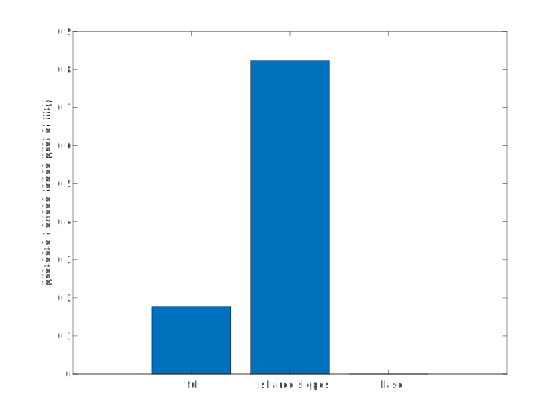

In [9]:
%FINAL

%plot protected exceedance probabilities
figure();bar(lle_sum.model_id,lle_sum.pep)
xticklabels({'full','shared slopes','base','adapt'})
ylabel('protected exceedance probability')

In [10]:
%FINAL
lle_sum(:,{'model_id','mname','Ef','pep'})


ans =

  3x4 table

    model_id            mname               Ef           pep    
    ________    _____________________    _________    __________

       1        {'priorOnly_full'   }      0.43221       0.17678
       2        {'priorOnly_noint'  }      0.56098       0.82322
       3        {'priorOnly_noprior'}    0.0068072    5.3809e-07



### are "adapt" weights different from 0 in model w/ adaptation-like terms?
NO.

In [11]:
%FINAL
F = load(fullfile(DATA_DIR,fits(4).fitmat));
fits_lapse_adapt = F.fits_lapse;clear F

prior_suffix = {'low','no','high'};

%are adapt weights different from 0?
for p=1:length(prior_suffix)
    [pval,h,stats] = signtest(fits_lapse_adapt.(['aSNR_' prior_suffix{p}]))
end


pval =

    0.5682


h =

  logical

   0


stats = 

  struct with fields:

    zval: NaN
    sign: 27


pval =

    0.3916


h =

  logical

   0


stats = 

  struct with fields:

    zval: NaN
    sign: 28


pval =

    1.0000


h =

  logical

   0


stats = 

  struct with fields:

    zval: NaN
    sign: 25

